In [1]:
import cv2
import numpy as np
import scipy as sc
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os

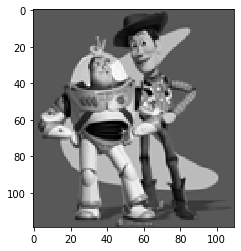

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB).astype('double')/255.0
plt.imshow(toy_img)

## Part 1 Toy Problem (20 pts)

In [45]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_out = np.zeros((toy_img.shape),dtype='double')
    
    im_h, im_w, _ = toy_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    M = im_h*(im_w-1) + (im_h-1)*im_w + 1
    N = im_h*im_w
    
    A = sc.sparse.lil_matrix((M,N))
    b = np.zeros((M,3))
    
    e = -1
    
    for i in range(im_h-1):
        for j in range(im_w):
            e += 1
            if j != im_w-1:
                A[e,int(im2var[i,j+1])] = 1
                A[e,int(im2var[i,j])] = -1
                b[e] = toy_img[i,j+1] - toy_img[i,j]
            else:
                A[e,int(im2var[i,j])] = -1
                b[e] = -toy_img[i,j]
    for j in range(im_w-1):
        for i in range(im_h):
            e += 1
            if i != im_h-1:
                A[e,int(im2var[i+1,j])]= 1
                A[e,int(im2var[i,j])]= -1
                b[e] = toy_img[i+1,j] - toy_img[i,j]
            else:
                A[e,int(im2var[i,j])]= -1
                b[e] = -toy_img[i,j]
    e += 1
    A[e,int(im2var[im_h-1,im_w-1])] = -1 
    b[e] = -toy_img[im_h-1,im_w-1]
    print('done')
    A = sc.sparse.csr_matrix(A)
    v = np.zeros((N,3))
    v[:,0] = sc.sparse.linalg.lsqr(A, b[:,0],atol=1e-14, btol=1e-14)[0]
    v[:,1] = sc.sparse.linalg.lsqr(A, b[:,1],atol=1e-14, btol=1e-14)[0]
    v[:,2] = sc.sparse.linalg.lsqr(A, b[:,2],atol=1e-14, btol=1e-14)[0]
    for i in range(im_h):
        for j in range(im_w):
            im_out[i,j,:] = v[im2var[i,j],:]
    return im_out

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error is:  2.5820846718892284e-10


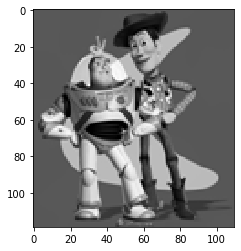

In [46]:
im_out = toy_reconstruct(toy_img)
if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))
    plt.figure()
    plt.imshow(im_out)

## Preparation

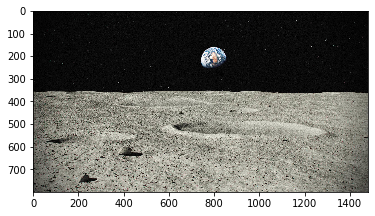

In [121]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/moon2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


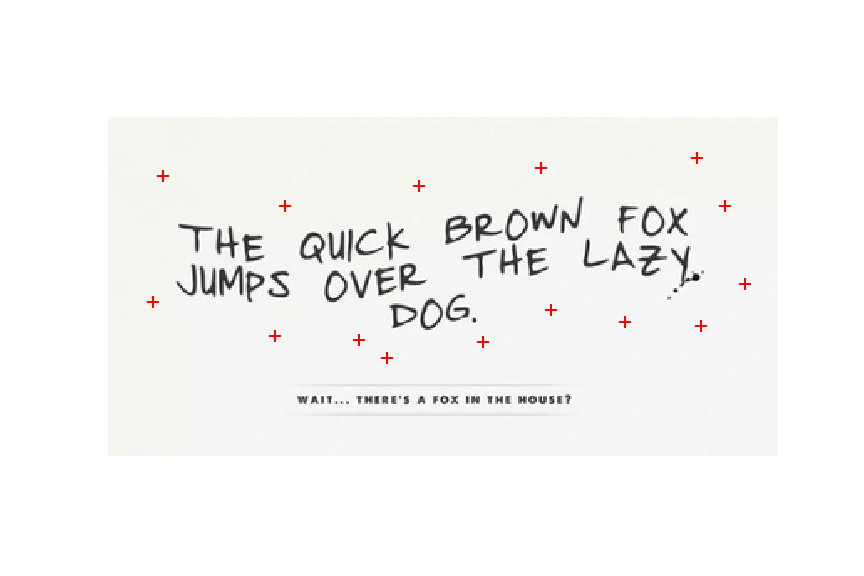

In [110]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/text.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

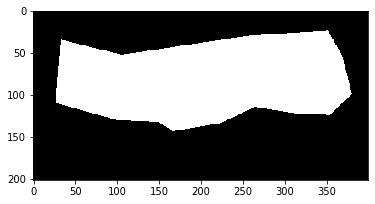

In [111]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


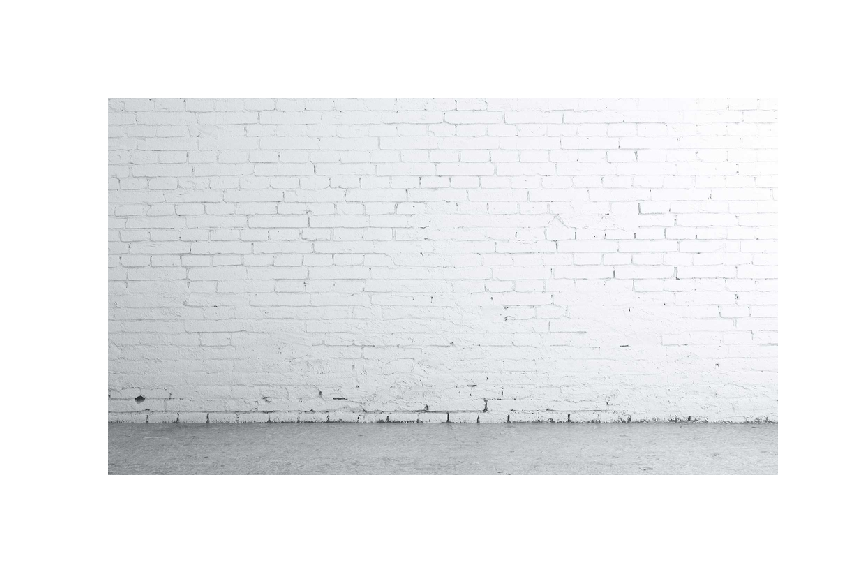

In [117]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

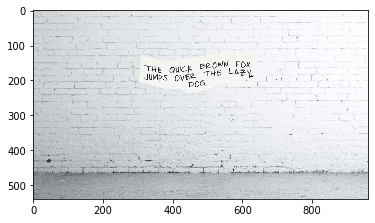

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

## Part 2 Poisson Blending (50 pts)

In [84]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    def idxs(i,j):
        return [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
    
    im_s = cropped_object
    im_t = background_img
    im_mask = object_mask
    
    [ii, jj] = np.nonzero(object_mask)
    
    im_h, im_w, chnls = im_s.shape
    im_out = np.zeros((im_t.shape),dtype='double')
    im_out[:,:,0] = ~im_mask * im_t[:,:,0]
    im_out[:,:,1] = ~im_mask * im_t[:,:,1]
    im_out[:,:,2] = ~im_mask * im_t[:,:,2]
    
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    M = 4*len(ii)+1
    N = im_h*im_w
    
    A = sc.sparse.lil_matrix((M,N))
    b = np.zeros((M,chnls))
    e = 0
    for n in range(len(ii)):
        i,j = ii[n],jj[n]
        for (i1, j1) in idxs(i,j):
            e += 1
            A[e,im2var[i,j]] = 1
            if(im_mask[i1,j1]):
                A[e,im2var[i1,j1]] = -1
                b[e,:] = im_s[i,j,:] - im_s[i1,j1,:]
            else:
                b[e,:] = im_s[i,j,:] - im_s[i1,j1,:] + im_t[i1,j1,:]
    print('done')
    A = sc.sparse.csr_matrix(A)
    v = np.zeros((N,chnls))
    v[:,0] = sc.sparse.linalg.lsqr(A,b[:,0])[0]
    v[:,1] = sc.sparse.linalg.lsqr(A,b[:,1])[0]
    v[:,2] = sc.sparse.linalg.lsqr(A,b[:,2])[0]
    for n in range(len(ii)):
        i,j = ii[n],jj[n]
        im_out[i,j,:] = v[im2var[i,j],:]
    return im_out

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


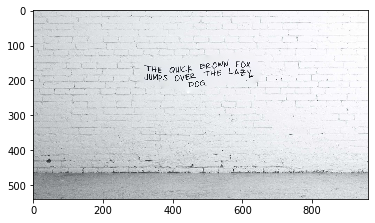

In [119]:
im_blend = poisson_blend(cropped_object, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [93]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO
    def idxs(i,j):
        return [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
    
    im_s = cropped_object
    im_t = background_img
    im_mask = object_mask
    
    [ii, jj] = np.nonzero(object_mask)
    
    im_h, im_w, chnls = im_s.shape
    im_out = np.zeros((im_t.shape),dtype='double')
    im_out[:,:,0] = ~im_mask * im_t[:,:,0]
    im_out[:,:,1] = ~im_mask * im_t[:,:,1]
    im_out[:,:,2] = ~im_mask * im_t[:,:,2]
    
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    M = 4*len(ii)+1
    N = im_h*im_w
    
    A = sc.sparse.lil_matrix((M,N))
    b = np.zeros((M,chnls))
    e = 0
    for n in range(len(ii)):
        i,j = ii[n],jj[n]
        for (i1, j1) in idxs(i,j):
            e += 1
            A[e,im2var[i,j]] = 1
            s_grad = im_s[i,j] - im_s[i1,j1]
            t_grad = im_t[i,j] - im_t[i1,j1]
            if(im_mask[i1,j1]):
                A[e,im2var[i1,j1]] = -1
                for ch in range(chnls):
                    if abs(s_grad[ch]) > abs(t_grad[ch]):
                        grad = s_grad[ch]
                    else:
                        grad = t_grad[ch]
                    b[e,ch] = grad
            else:
                for ch in range(chnls):
                    if abs(s_grad[ch]) > abs(t_grad[ch]):
                        grad = s_grad[ch]
                    else:
                        grad = t_grad[ch]
                    b[e,ch] = grad + im_t[i1,j1,ch]
    print('done')
    A = sc.sparse.csr_matrix(A)
    v = np.zeros((N,chnls))
    v[:,0] = sc.sparse.linalg.lsqr(A,b[:,0])[0]
    v[:,1] = sc.sparse.linalg.lsqr(A,b[:,1])[0]
    v[:,2] = sc.sparse.linalg.lsqr(A,b[:,2])[0]
    for n in range(len(ii)):
        i,j = ii[n],jj[n]
        im_out[i,j,:] = v[im2var[i,j],:]
    return im_out

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


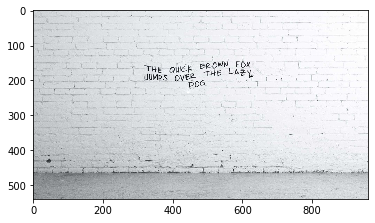

In [120]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [17]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [18]:
def laplacian_blend(img1, img2):
    pass

## More gradient domain processing (up to 20 pts)